# Univariate Regression 

In [1]:
import scipy.stats as stats
from scipy.stats.stats import pearsonr
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [3]:
df = pd.read_csv('/Users/desert/desert_workspace/desert_data/fd_data.csv')
df = df.drop(['Unnamed: 0','State'], axis=1)


df['pct_nonwhite'] =  1 - df['PCT_WHITE'] 
cols = df.columns.tolist()
df.head()

,County,POP2010,food_deserts,pop_in_des,perc_lila,n_tracts,urban_des,rural_des,n_urban,n_rural,...,food_dx,opiods_rx_1000,opiods_greater_than_stateavg,MILK_PRICE10,SODA_PRICE10,MILK_SODA_PRICE10,PCH_FFR_07_12,FFR07,FFR12,pct_nonwhite
0,Alameda,1510271,15,56082.0,0.018032,360,15.0,0.0,354,6,...,29.597337,557.20,0,1.122215,1.164422,0.891575,8.902878,1112.0,1211,0.483413
1,Alpine,1175,0,0.0,0.266288,1,0.0,0.0,0,1,...,0.000000,578.68,0,1.032918,1.089488,0.877073,-50.000000,2.0,1,0.310400
2,Amador,38091,0,0.0,0.149514,9,0.0,0.0,0,9,...,13.126460,1244.76,1,1.032918,1.089488,0.877073,-5.555556,18.0,17,0.055533
3,Butte,220000,14,58979.0,0.145583,51,13.0,1.0,38,13,...,27.727273,1389.20,1,0.996443,1.130546,0.815374,2.684564,149.0,153,0.096562
4,Calaveras,45578,0,0.0,0.203345,10,0.0,0.0,2,8,...,10.970205,1068.98,1,1.032918,1.089488,0.877073,-7.407407,27.0,25,0.060800


## Accounting for Variable County Sizes
Before we can compare counties, we need to perform some preprocessing. This is neccessary because our counties vary considerably in size. If we left our data as is, the values of larger counties would dominate our results, and reaffirm the obvious (larger counties are likely to have more food deserts). Below we will calculate the percentage values of our count based features to address this issue. 

It is important to note, this will slightly change how we interpret our results. 
Instead of finding the correlations between varying counts, we will recieve the correlations between varying percentages. 

Again, this is because the  coefficients of our explanatory variables provide the change in response variable for a given one unit increase in the explanatory variable. Since we are changing our explanatory variable to percentages, we will interpret them as such. 

In addition to calculating percentages, we also drop some columns to slim down our dataframe.

In [4]:
def order(frame,var):
    varlist =[w for w in frame.columns if w not in var]
    frame = frame[var+varlist]
    return frame 

df[['pop_in_des','total_housing_units', 'pop_in_group_housing']] = df[['pop_in_des','total_housing_units', 'pop_in_group_housing']].div(df.POP2010, axis=0)

df['urban_des'] = df['urban_des'].div(df.n_urban, axis=0)
df['rural_des']=df['rural_des'].div(df.n_rural, axis=0)

df[['n_rural','n_urban','LowIncomeTracts','low_vehicle_tracts']] = df[['n_rural','n_urban','LowIncomeTracts','low_vehicle_tracts']].div(df.n_tracts, axis=0)
# counties with no low income tracts will result in nan values
df=df.fillna(0)

df = order(df,['des_percent','pop_in_des','perc_lila']).set_index('County')
df.to_csv('/Users/desert/desert_workspace/desert_data/multi_fd_data.csv')

### EDA

Before moving forward, lets refresh our memory of what our dataset looks like. This EDA is an important step, and will help us identify interesting relationships that we would like to explore further. Below is a list of plots that can help us gain a better understanding of our dataset:

* distplot - contains a histogram that shows the frequencies of observations as well as a kernel density estimate. One advantage of using seaborn's distplot is that it allows us to test the distribution shape of a feature by setting kde=False, and fit=scipy.stats.distribution. The  probability density function (PDF), that is passed to fit shows the probability of values in the distribution.   

* heatmap - provides a quick means for assessing how variables relate to one another. Depicts a correlation matrix that shows the magnitude and direction of correlations that exist between the included features.   

* pairplot - provdes pairwise scatter plots for every variable passed in, as well as a kde or histogram of the each features distribution. This helps us select the most meanigful features in our data set, and identify any nonlinear relationships. One word of caution - this plot is very computationally expensive, so it is best to limit the number of features passed in to 6 or less.

* boxplot - helps to assess categorical variables, and the presence of outliers. 


μ represents the mean (which coincides with the median and the mode) and the symbol σ is the variance.

### Assessing the Distributions of Target Variables

Our original goal was to determine the effect food deserts have on the health of CA counties.  With this in mind lets assess the distributions of some potential target variables for our analysis.


##### food_deserts: 
The number of food deserts present in a county.  
As y: Reflects what types of countys have the most food deserts (does not account for county size - large counties would dominate result). 
      
      
##### des_percent:
The percentage of census tracts that were labeled a food desert
As y: Reflects what types of countys likely to have a high prevelance of food deserts (does not account for county size - small counties would dominate result due to their small denominator, total number of census tracts). 
  
  
##### pop_in_des:
The proportion of county population living in a food desert census tract.
As y: Explains what types of counties are impacted the most by food deserts.
   
    
##### perc_lila:
The percentage of population that live in low access/ low income area. This includes citizens who live in LILA areas but did not meet the criteria in the following definition:     
        Food Desert:  A census tract that meets both low-income and low-access criteria including: 1. poverty rate is greater than or equal to 20 percent OR median family income does not exceed 80 percent statewide (rural/urban) or metro-area (urban) median family income; 2. at least 500 people or 33 percent of the population located more than 1 mile (urban) or 10 miles (rural) from the nearest supermarket or large grocery store.
As y: Explains what types of counties tend to have the highest proportion of citizens with low incomes and low access to food. 
        

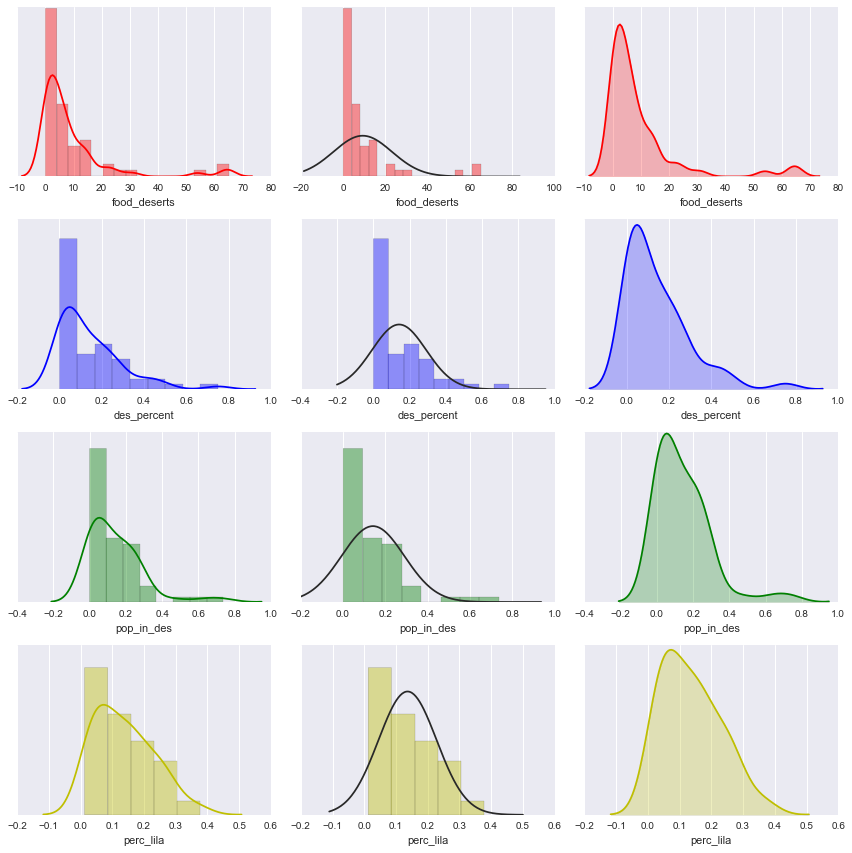

In [5]:
from scipy.stats import norm

f, axes = plt.subplots(4, 3, figsize=(12, 12))
sns.despine(left=True)

d = df['food_deserts']
d1 = df['des_percent']
d2 = df['pop_in_des']
d3 = df['perc_lila']

colors = ['r','b','g','y']
potential_ys = [d,d1,d2,d3]
ixs = range(len(potential_ys))
for var, c, i in zip(potential_ys,colors,ixs):
    sns.distplot(var, color=c, ax=axes[i, 0])
    sns.distplot(var, color=c, fit=norm, kde=False, ax=axes[i, 1])
    sns.distplot(var, hist=False, color=c, kde_kws={"shade": True}, ax=axes[i, 2])
    
plt.setp(axes, yticks=[])
plt.tight_layout()

For now, let's focus on pop_in_des as our y variable.

### Obtaining a broad look at Feature relationships

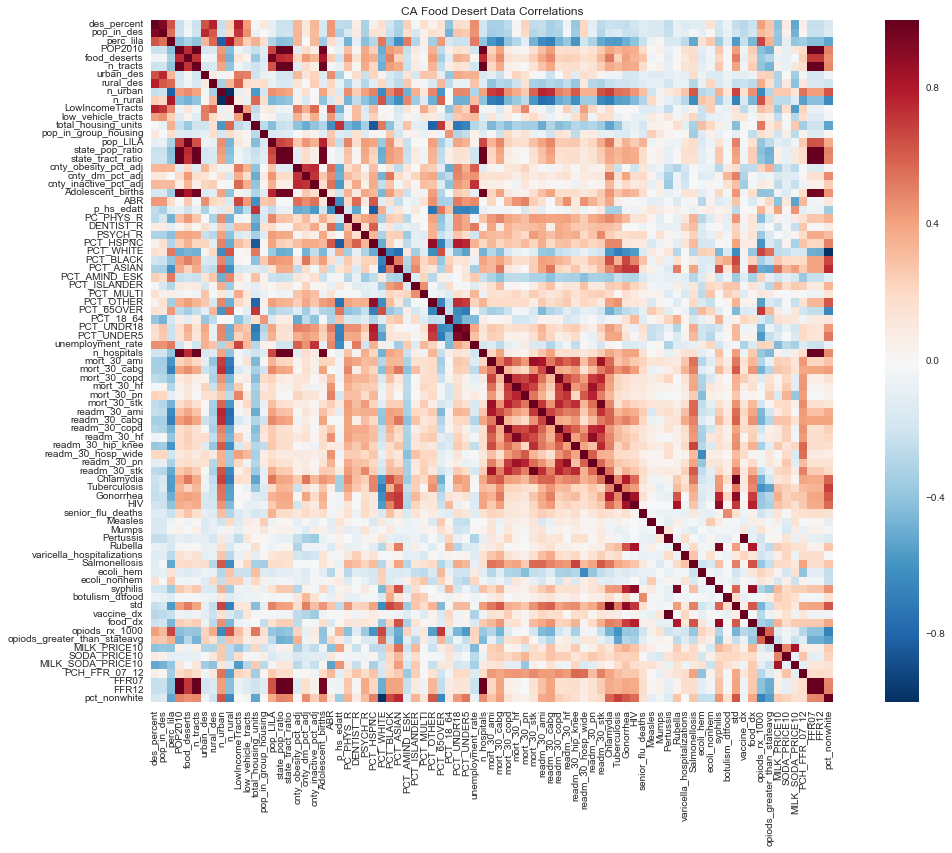

In [6]:
def standardize(variable):
    return (variable - np.mean(variable)) / np.std(variable)


data = standardize(df)

# generates a correllation matrix using pandas
corrmat = data.corr()

# Sets up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Drawa the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

There are a few things we should note in this graph:
* Not all hospitals care for stroke, CABG, or knee and hip surgery patients. Therefore we are likely to see less occurances of these features for smaller rural hospitals. Also, it is important to note that the hospital mortality and readmission feature Nan values were filled with 0. Therefore the correlations we are seeing with these features are likely just a reflection of county size (larger the counties have more hospitals).  

Despite this caveat we can still make some interesting inferences from correlations with pop_in_des (The proportion of county population living in a food desert census tract). Counties that are impacted the most by food deserts tend to be:
- More rural, low income, and less access to vehicles
- Have more obese, inactive, and younger residents
- Have higher adolescent birth rates
- Have lower education and employment rates
- Have less hospitals
- Have more opiod prescriptions


### A closer look at selected features

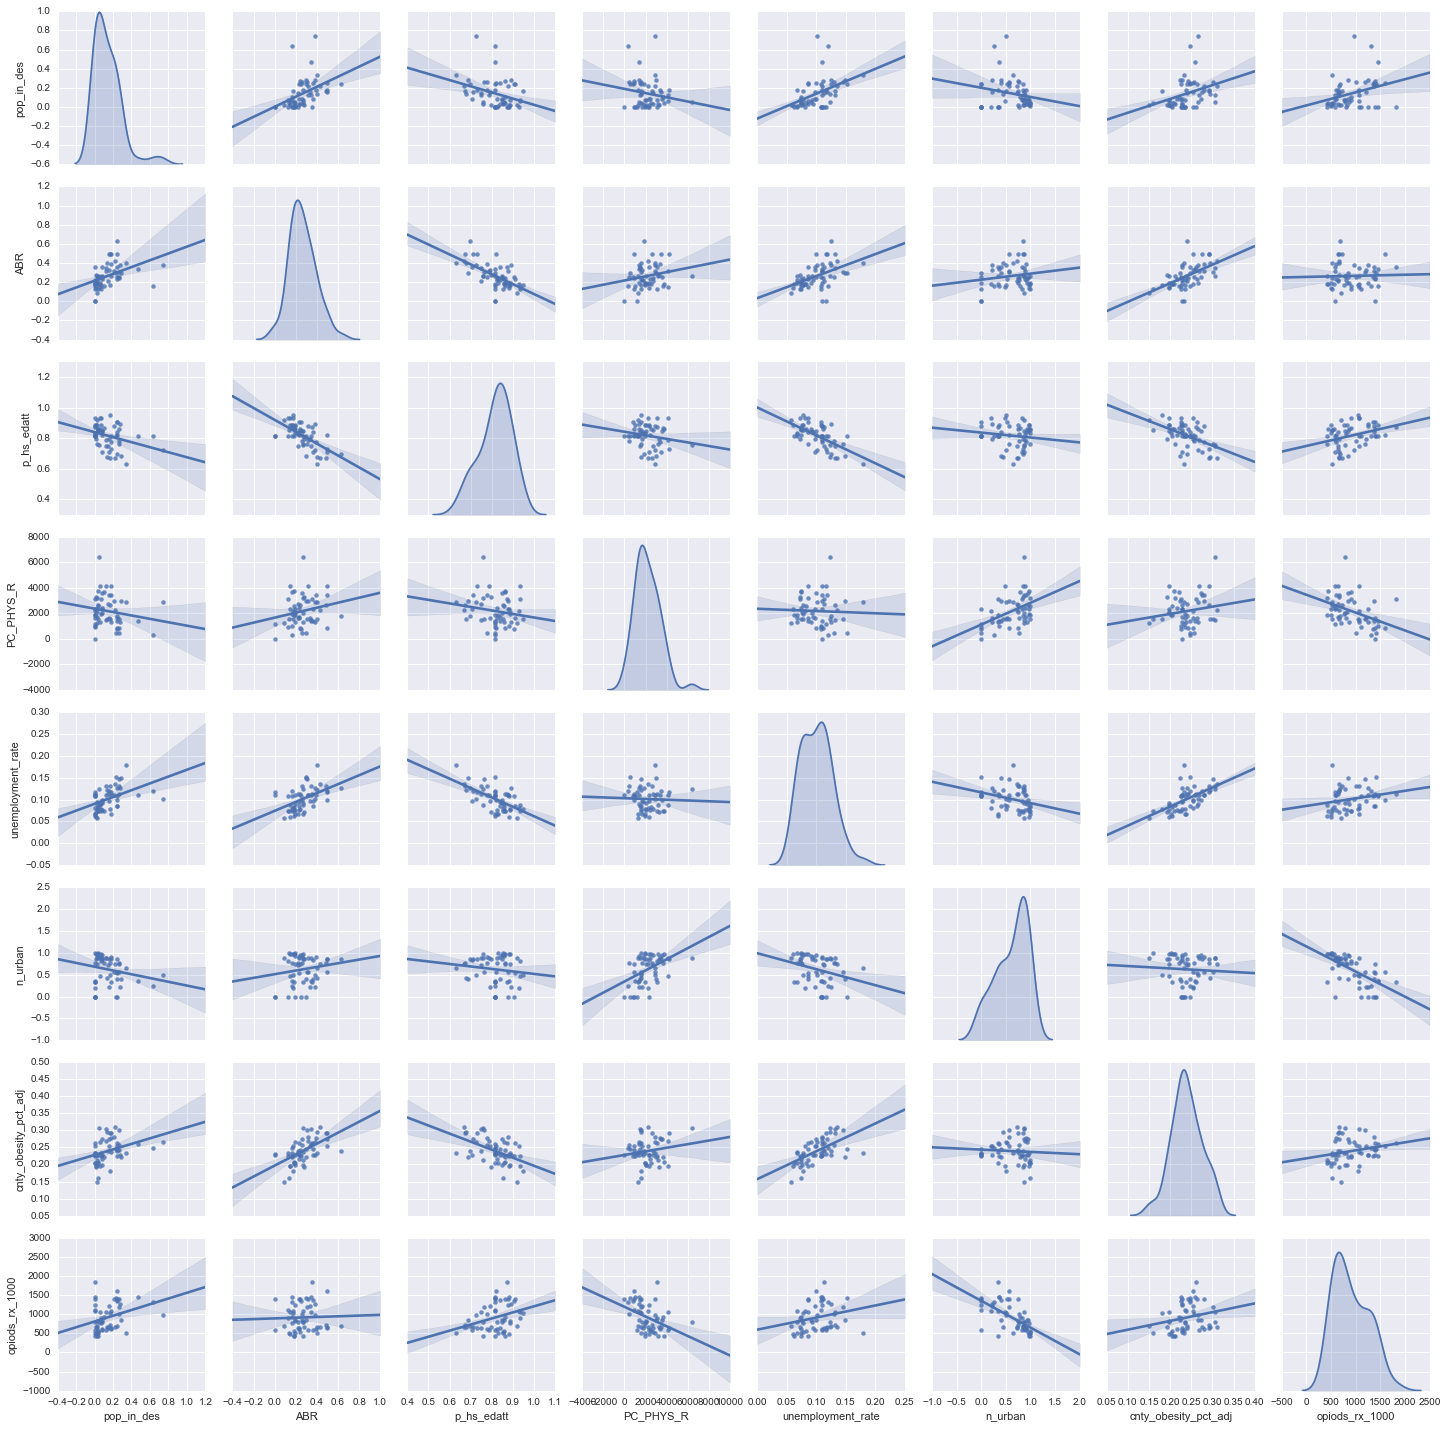

In [7]:
pairs=df[['pop_in_des','ABR','p_hs_edatt','PC_PHYS_R','unemployment_rate','n_urban','cnty_obesity_pct_adj','opiods_rx_1000']]
g = sns.pairplot(pairs, diag_kind="kde", kind='reg',
                 diag_kws=dict(shade=True))

___________
# An Example of Univariate Regression

## Goal
Identify characteristics of counties that are most effected by food deserts.
## Hypotheses 
Hypothesis 1: Counties with a greater percentage of citizens living in food deserts tend to also have a greater percentage of obese citizens.  

Hypothesis 2: County level obesity rate is a useful measure in predicting the percentage of citizens living in food deserts  

To test this hypothesis, I will assess if a correlation exists between these 2 features. I then will implement a univariate linear regression model to determine whether county-level obesity rates is a useful in predicting the proportion of citizens living in Census Tracts labeled as food deserts. 

* x = cnty_obesity_pct_adj: County obesity rates (age-adjusted)
* y = pop_in_des: Percentage of citizens living in Food deserts  (The proportion of county population living in a food desert census tract).

Below is a plot of the two features we have selected:

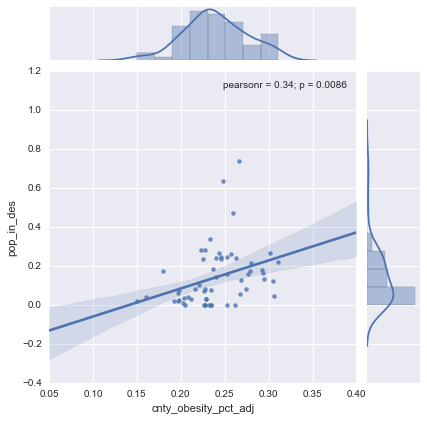

In [8]:
sns.jointplot(x='cnty_obesity_pct_adj', y='pop_in_des', data=df, kind='reg')

Correlation between two variables suggests that there is some sort of relationship between them. Correlation is assessed using the following formula:

$$ r = 1/n * {sum(xi - mean(x1) * (y-mean(y)) / std(xi * std(y)} $$

Values range from -1 to 1, and reflect the directionality and intensity of the relationship.
* values  > 0: suggests a positive correlation, as x increases y increases and as x deceases y decreases. The closer the values in to 1 the more dependent the features are on one another.
* values < 0:  suggests a negative correlation, as x increases y decreases, and vice versa. The closer the values in to -1 the more dependent the features are on one another.
* values = 0: suggests there is no relation between the two variables, meaning their values are completely independent of one another. 

If we do not standardize the variables we are comparing we will recieve a different measure of association called the covariance. This is less ideal for comparing two quantative features because it does not account for different scales. This measure is obtained by the formula below.

$$ cov(xi,y) = 1/n * sum(xi - mean(x1) * (y-mean(y)) $$


The functions below implement these formulas and compare the return result to scipy's pearsonr function which provides the correlation between two arrays, in addition to the p value.

In [9]:

def covariance(feat_1, feat_2, bias=0):
    observations = float(len(feat_1))
    return np.sum((feat_1 - np.mean(feat_1)) * (feat_2 - np.mean(feat_2)))/(observations-min(bias,1))

def standardize(feat):
    return (feat - np.mean(feat)) / np.std(feat)

def correlation(feat1,feat2,bias=0):
    return covariance(standardize(feat1), standardize(feat2),bias)


print ('Homemade correlation function: %0.5f' % (correlation(df['cnty_obesity_pct_adj'], 
                                                             df['pop_in_des'])))

print ('Result using Scipy, correlation and p-val: %0.5f & %0.5f' % pearsonr(df['cnty_obesity_pct_adj'],
                                                                                       df['pop_in_des']))


Homemade correlation function: 0.34204
Result using Scipy, correlation and p-val: 0.34204 & 0.00859


With a correlation of 0.34204, and a p value of 0.00859, we can state there is a statistically significant positive correlation between county diabetes rates and the percentage of county residents that live in food deserts. 

Now that we know there is some sort of relationship between these two features, lets now try to see how accurately we can predict the percentage of county residents living in food deserts when given county diabetes rates.

To do this we will use Univariate linear regression which utilizes the following formula:

$$ y = a + bX $$
$$ y = dependent$$
$$ X = explanatory$$
$$ a = bias\ (y\ intercept\ or\ the\ value\ of\ y\ when\ x=0.)$$

Lets use Statsmodels to implement our model

In [10]:
X=df['cnty_obesity_pct_adj']
y=df['pop_in_des']
X = sm.add_constant(X) # adds bias

lr_model1 = sm.OLS(y,X).fit()
lr_model2 = smf.ols(formula='pop_in_des ~ cnty_obesity_pct_adj', data=df).fit()

# The line below will provide identical output to our first model.
#lr_model2.summary() 
lr_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             pop_in_des   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     7.420
Date:                Wed, 10 Aug 2016   Prob (F-statistic):            0.00859
Time:                        21:57:20   Log-Likelihood:                 31.851
No. Observations:                  58   AIC:                            -59.70
Df Residuals:                      56   BIC:                            -55.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                   -0.2038      0.128     -1.592      0.117        -0.460     0.053
cnty_obesity_pct_adj     1.4398      0.529      2.724      0.009         0.381     2.499
==============================================================================
Omnibus:                       35.873   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.424
Skew:                           1.902   Prob(JB):                     1.04e-19
Kurtosis:                       7.659   Cond. No.                         29.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Statsmodels OLS summary output
### First Table
##### Baseline model information
• Dep. Variable - The model's target variable   
• Model: The type of model made (OLS ='s ordinary least squares)   
• No. Observations: The number of observations the model was trained on.   
• DF Residuals: The number of observations minus the number of parameters. We have 56 because we passed in 58 observations, and 2 parameters (obesity rates, and contant). 58-2 = 56   
• DF Model: The number of explanatory variables, excluding the constant.    
##### Goodness of model fit
• R-squared: Also reffered to as the coefficient of determination, and reflects how close the data are to the fitted regression line. It signifies how much more variance the model explains in comparison what is unexplained by the mean.    
• Adj. R-squared: The adjusted R-squared is a modified version of R-squared that has been adjusted for the number of predictors in the model. The adjusted R-squared increases only if the new term improves the model more than would be expected by chance. It decreases when a predictor improves the model by less than expected by chance. 
• F-statistic: Reflects whether the explanatory variables coefficients are different from zero. This becomes more important in multivariate regression. The high values suggests strong predictors.     
• Prob (F-statistic): This is the probability that you got that F-statistic was due to chance. Ideally this value should be less than a predefined significance level, such as 0.05.    
• AIC: This is the Akaike Information Criterion, which evaluates model complexity. Lesser is better. Becomes useful during model comparison.  
• BIC: This is the Bayesian Information Criterion. Similiar to AIC, but penalizes models with high paramaters more severly.   

### Second Table
##### Explanatory Variable Statistics
• coef: The estimated coefficient of the beta or the explantory variable. The coefficient of our explanatory variable, obesity rate, provides the change in county food desert prevelance for every unit increase in obesity rate. So if the coeff is 1.4398, and the constant is -0.2038, we would use the following formula to predict the percentage of county census tracts that are food deserts:   
$$ Percent of citizens in food desert = 1.4398 * x_{obesity prev} * -0.2038$$
• std err: The standard error of the explanatory variables coef, which reflects how confident we can be in the coef. Higher values reflect more uncertainty   
• t: The t-statistic value, reflects whether the coefficent is not zero.   
• P > |t|: The probability that the coefficient is different from zero just by chance    
• [95.0% Conf. Interval]: The upper and lower bounds of the coefficient estimate for a 95% confidence interval .

### Bottom Table
##### Model Residuals (difference between predictions an actual response variable values)
• Skewness: Refects the symmetry of residuals. Postive values = right tail, Negative values = left tail, Close to Zero values = symmetric. Here we see our residuals have a right tail.   
• Kurtosis: The distribution shape of the residuals. Postive values = high peak, Negative values = flat, Close to Zero values = bell shaped. Here we see our residuals have a high peak.   
• Omnibus D'Angostino's test: Mix of the tests above  
• Prob(Omnibus): The probility of the Omnibus statistic  
• Jarque-Bera: Also reflects skewness and kurtosis.  
• Prob (JB): The probility of the JB statistic.  
• Durbin-Watson: Tests for correlation among the residuals, used with Time series data.   
• Cond. No: This is a test for multicollinearity. Important in multivariate analysis.  

Statsmodels allows us to access the coeffcients with the params method, and the predictions of the model with .predict(data).  


In [11]:
print (lr_model1.params)
betas = np.array(lr_model1.params)
fitted_values =lr_model1.predict(X)

const                  -0.203794
cnty_obesity_pct_adj    1.439796
dtype: float64




Using our model's predictions we can calculate the R squared value manually as well. This is done by calculating the following: 

* Mean sum of squared errors - The unexplained variance of the proportion of county population living in a food desert (the sum of squared differences from the mean). 
  
$$ mean\ sum\ of\ squared\ errors = sum(dependent\ variable \ values - mean( dependent\ variable \ values )^2)$$
  
* Residual sum of squared errors - The residual sum of squares, the difference between the actual and predcicted values (regresion sum of squares) 
  
$$ Residual\ sum\ of\ squared\ errors = sum(actual \ values - predicted \ values )^2)$$
  
* R squared - the amount of variance explained by the model,  SSD - SSR / SSD
  
$$ R\ squared = (mean\ sum\ of\ squared\ errors - Residual\ sum\ of\ squared\ errors) / mean\ sum\ of\ squared\ errors )$$



In [12]:
mean_sum_squared_errors = np.sum((df['pop_in_des']-df['pop_in_des'].mean())**2)
regr_sum_squared_errors = np.sum((df['pop_in_des']-fitted_values)**2)
r2 = (mean_sum_squared_errors - regr_sum_squared_errors) / mean_sum_squared_errors
print("SSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)

SSD = 1.28232351825
SSR = 1.13230279992
R2 = 0.116991317861


Now that we have a sence of how good our model is, we should asses how we can improve it's performance. Below are some common causes of underperformance:

##### Outliers
Observations with dependent variable values that differ significantly from other observations with similar explanatory variable values. These observations will have large residuals in a residual plot.
##### Leverage
Observations with explanatory variable values that differ significantly from other observations. These observations will have disproportionate effects on coefficients.
##### Influence
Obsevations that have a significant impact on the outcome values due to one or both of the above.


Lets visualize our model in a dataframe and some plots to find problematic observations.

In [13]:
lr_pred = pd.DataFrame({'cnty_obesity_pct_adj':X['cnty_obesity_pct_adj'],'Predicted_Output(pop_in_des)':fitted_values,'Actual_Output(pop_in_des)':y})
lr_pred['mean'] = lr_pred['Actual_Output(pop_in_des)'].mean()
lr_pred.head()

,Actual_Output(pop_in_des),Predicted_Output(pop_in_des),cnty_obesity_pct_adj,mean
County,,,,
Alameda,0.037134,0.089924,0.204,0.141062
Alpine,0.000000,0.130238,0.232,0.141062
Amador,0.000000,0.124479,0.228,0.141062
Butte,0.268086,0.146076,0.243,0.141062
Calaveras,0.000000,0.160474,0.253,0.141062


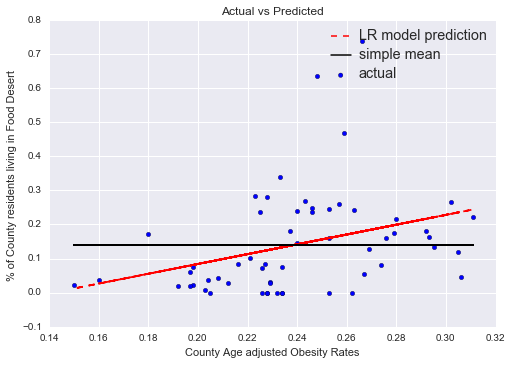

In [14]:

xval = lr_pred['cnty_obesity_pct_adj']
xp = lr_pred['Predicted_Output(pop_in_des)']
yval = lr_pred['Actual_Output(pop_in_des)']
m = lr_pred['mean']


fig, ax = plt.subplots()
ax.plot(xval, xp, 'k--', color='r',label='LR model prediction')
plt.scatter(xval, yval, label='actual')
ax.plot(xval, m, 'k', label='simple mean')

legend = ax.legend(loc='best', shadow=True)

frame = legend.get_frame()
frame.set_facecolor('0.90')

for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  
    
ax.set_xlabel('County Age adjusted Obesity Rates')
ax.set_ylabel('% of County residents living in Food Desert ')
plt.title('Actual vs Predicted')
plt.show()

The graph above compares our model's prediction compared to the a model that predicted the mean for every observation. We can see our model fits the data better than the mean, however it is still far from perfect. We can also see some outliers exist in the top right corner. These will need to be addresed to improve our models performance. But before we address these let's look at one more plot that can help us evalute our model that is called a residual plot.  It shows the difference between the actual and predicted values of the response variable (pop_in_des). 


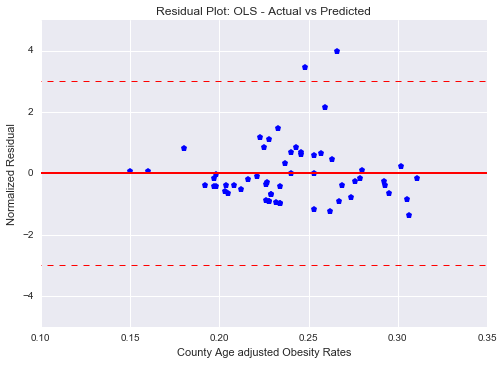

In [15]:
residuals = lr_pred['Actual_Output(pop_in_des)']-fitted_values
normalized_residuals = standardize(residuals)
x_range = [lr_pred['Actual_Output(pop_in_des)'].min(),lr_pred['Actual_Output(pop_in_des)'].max()]
residual_scatter_plot = plt.plot(lr_pred['cnty_obesity_pct_adj'], normalized_residuals,'bp')
mean_residual = plt.plot([int(x_range[0]),round(x_range[1],0)], [0,0],'-', color='red', linewidth=2)
upper_bound = plt.plot([int(x_range[0]),round(x_range[1],0)], [3,3], '--', color='red', linewidth=1)
lower_bound = plt.plot([int(x_range[0]),round(x_range[1],0)], [-3,-3],'--', color='red', linewidth=1)
plt.ylim([-5,5])
plt.xlim([0.10,0.35])
plt.title('Residual Plot: OLS - Actual vs Predicted')
plt.xlabel('County Age adjusted Obesity Rates')
plt.ylabel('Normalized Residual')
plt.show()

Our model's residual show there are a few points lying outside the normalized residual values. This reaffirms outliers are present within the response variable pop_in_des, which is contributing to poor performance.

We can also assess whether our explanatory variable contains outliers through a Influence plot. The plot depicts each observations residual (the difference between actual and predicted target variable value) on the y axis, and leverage on the x axis. Leverage can be though of as the distance between the observations explanatory variable value from other observations explanatory variable values. Statsmodels has a built in function to create this type of plot, which can be seen below.

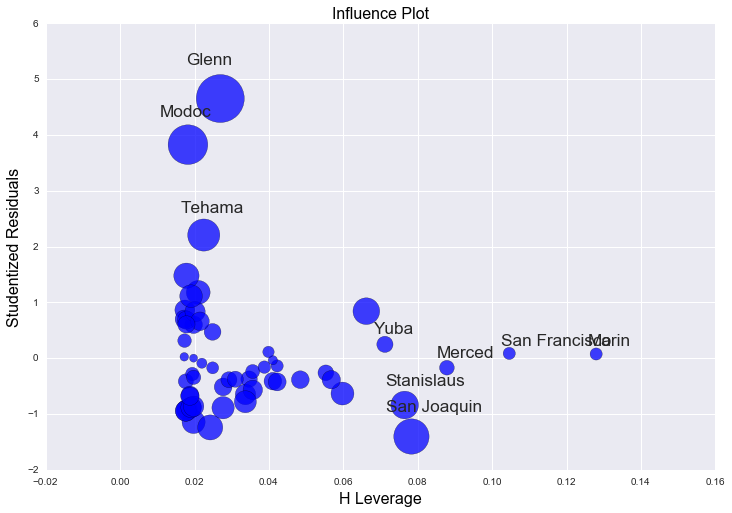

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(lr_model1, ax=ax, criterion="cooks")

Lets take a closer look at the influential observations identified above.

In [17]:
print "Dataset means: \n",df[['pop_in_des','cnty_obesity_pct_adj']].mean()
print "\nDataset std: \n",df[['pop_in_des','cnty_obesity_pct_adj']].std()

print "\nObs that contain target variable (pop_in_des) outliers: "
print "\nGlenn values : \n", df[['pop_in_des','cnty_obesity_pct_adj']].ix['Glenn']
print "\nModoc values : \n", df[['pop_in_des','cnty_obesity_pct_adj']].ix['Modoc']

print "\nObs that contain Explanatory variable (cnty_obesity_pct_adj) outliers: "
print "\nMarin values : \n", df[['pop_in_des','cnty_obesity_pct_adj']].ix['Marin']
print "\nSan Francisco values : \n", df[['pop_in_des','cnty_obesity_pct_adj']].ix['San Francisco']

Dataset means: 
pop_in_des              0.141062
cnty_obesity_pct_adj    0.239517
dtype: float64

Dataset std: 
pop_in_des              0.149990
cnty_obesity_pct_adj    0.035632
dtype: float64

Obs that contain target variable (pop_in_des) outliers: 

Glenn values : 
pop_in_des              0.73711
cnty_obesity_pct_adj    0.26600
Name: Glenn, dtype: float64

Modoc values : 
pop_in_des              0.636795
cnty_obesity_pct_adj    0.248000
Name: Modoc, dtype: float64

Obs that contain Explanatory variable (cnty_obesity_pct_adj) outliers: 

Marin values : 
pop_in_des              0.022285
cnty_obesity_pct_adj    0.150000
Name: Marin, dtype: float64

San Francisco values : 
pop_in_des              0.038215
cnty_obesity_pct_adj    0.160000
Name: San Francisco, dtype: float64


The following is another useful plotting function statsmodels offers called plot_regress_exog.
The left upper most plots our 2 variables with confidence intervals for the model. Again, we can see that there are 4 outliers, which lie outside the confidence intervals.  The right uppermost plot is another residual plot, similiar to the one we made above. The bottom plots are partial regression, and Component-Component plus Residual plot, which are relevant for multivariate models for trouble shooting different predictors. 

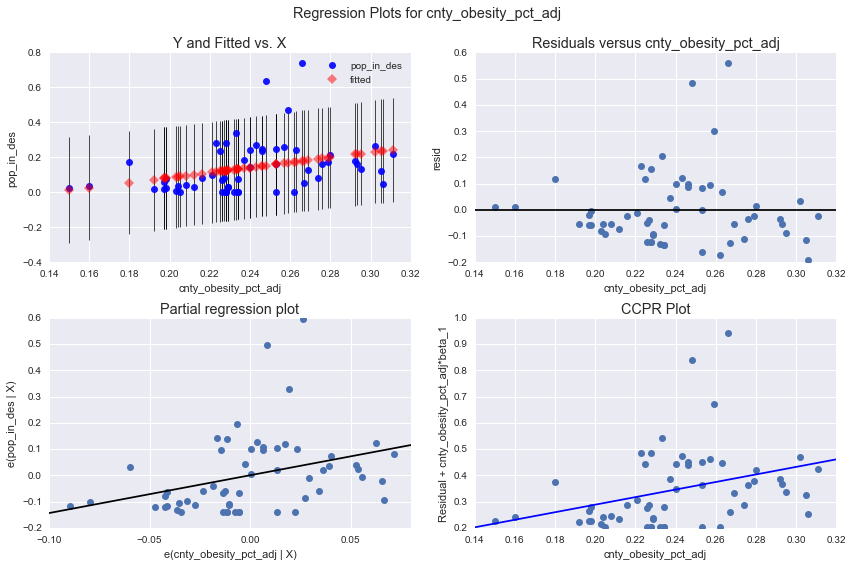

In [18]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(lr_model1, "cnty_obesity_pct_adj", fig=fig)

## Model adjustment

Lets try to improve our performance. To do so we will try two different methods:
* Robust Regression 
* Manual outlier exclusion

First lets make a robust model that weights observations to exclude outliers. This can be done using statsmodels rlm

In [19]:
from statsmodels.formula.api import rlm
robust_model = rlm("pop_in_des ~ cnty_obesity_pct_adj", data=df,
                      M=sm.robust.norms.TukeyBiweight(3)).fit(conv="weights")
print(robust_model.summary())

rbetas = np.array(robust_model.params)
rbetas

                    Robust linear Model Regression Results                    
Dep. Variable:             pop_in_des   No. Observations:                   58
Model:                            RLM   Df Residuals:                       56
Method:                          IRLS   Df Model:                            1
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 10 Aug 2016                                         
Time:                        21:57:23                                         
No. Iterations:                    45                                         
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept               -0.1918 

array([-0.19179074,  1.22152388])

We can see that our values have changed by excluding the outliers. Lets visually compare the two models below. 

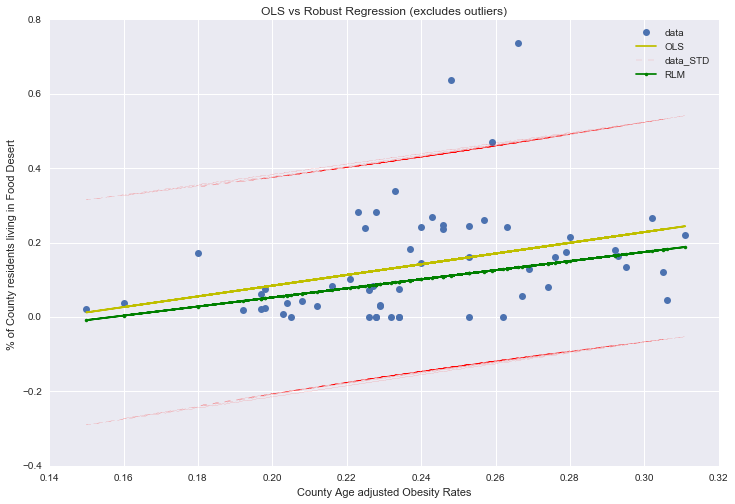

In [20]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(xval, yval, 'o',label="data")
prstd, iv_l, iv_u = wls_prediction_std(lr_model1)
ax.plot(xval, lr_model1.fittedvalues, 'y-', label="OLS")
ax.plot(xval, iv_u, color='r', linestyle='--', linewidth=.1)
ax.plot(xval, iv_l, 'r--', linestyle='--', linewidth=.1, label='data_STD')
ax.plot(xval, robust_model.fittedvalues, 'g.-', label="RLM")
ax.legend(loc="best")
ax.set_xlabel('County Age adjusted Obesity Rates')
ax.set_ylabel('% of County residents living in Food Desert ')
plt.title('OLS vs Robust Regression (excludes outliers)')

The plot above shows the influence the outliers had on our regression line, and how the robust model is better suited to predict observations lying within 3 standard deviations of the mean. Lets make a residual plot and calculate the robust models R squared for comparison.

In [21]:
weights = robust_model.weights
idx = weights > 0
X = robust_model.model.exog[idx.values]
ww = weights[idx] / weights[idx].mean()
hat_matrix_diag = ww*(X*np.linalg.pinv(X).T).sum(1)
resid = robust_model.resid
resid2 = resid**2
resid2 /= resid2.sum()
nobs = int(idx.sum())
hm = hat_matrix_diag.mean()
rm = resid2.mean()

In [22]:
mean_sum_squared_errors = np.sum((df['pop_in_des']-df['pop_in_des'].mean())**2)
regr_sum_squared_errors = np.sum((df['pop_in_des']-fitted_values)**2)
r2 = (mean_sum_squared_errors - regr_sum_squared_errors) / mean_sum_squared_errors
print("For OLS\nSSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)

mean_sum_squared_errors = np.sum((df['pop_in_des'].ix[idx]-df['pop_in_des'].ix[idx].mean())**2)
regr_sum_squared_errors = np.sum((df['pop_in_des'].ix[idx]-robust_model.fittedvalues)**2)
r2 = (mean_sum_squared_errors - regr_sum_squared_errors) / mean_sum_squared_errors
print("\nFor Robust Regression\nSSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)

For OLS
SSD = 1.28232351825
SSR = 1.13230279992
R2 = 0.116991317861

For Robust Regression
SSD = 0.53695315082
SSR = 0.469973020814
R2 = 0.124741106192


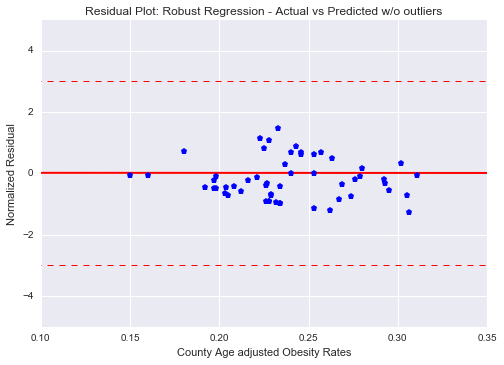

In [23]:
robnormalized_residuals = standardize(resid)
x_range = [lr_pred['Actual_Output(pop_in_des)'].ix[idx].min(),lr_pred['Actual_Output(pop_in_des)'].ix[idx].max()]
mean_residual = plt.plot([rm,0], '-', color='red', linewidth=2)
plt.plot(X[:,1], robnormalized_residuals[idx],'bp')
upper_bound = plt.plot([3,3], '--', color='red', linewidth=1)
lower_bound = plt.plot([-3,-3],'--', color='red', linewidth=1)
plt.ylim([-5,5])
plt.xlim([0.10,0.35])

plt.title('Residual Plot: Robust Regression - Actual vs Predicted w/o outliers')
plt.xlabel('County Age adjusted Obesity Rates')
plt.ylabel('Normalized Residual')
plt.show()

As you can see the robust model residual plot is free of outliers. The plot below depicts the observations leverages by normalized residual values, allowing us to see which observations are having the strongest effects on our robust model's performance and the estimated coefficients it includes.

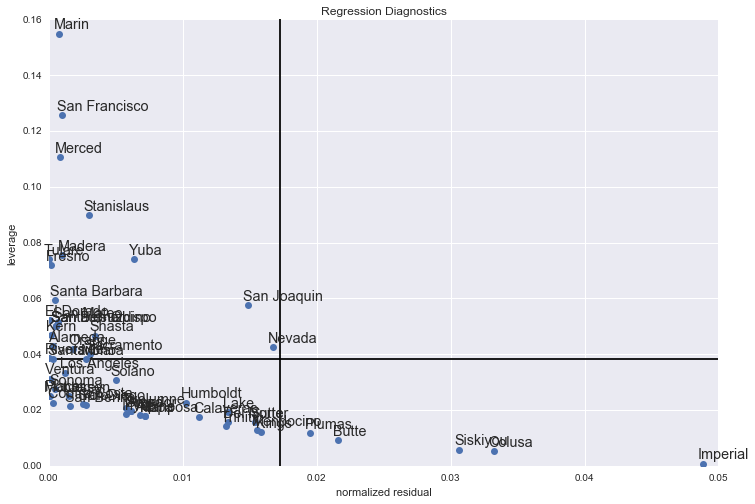

In [24]:
from statsmodels.graphics import utils
from statsmodels.compat import lzip

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(resid2[idx], hat_matrix_diag, 'o')
ax = utils.annotate_axes(range(nobs), labels=robust_model.model.data.row_labels[idx],
                    points=lzip(resid2[idx], hat_matrix_diag), offset_points=[(-5,5)]*nobs,
                    size="large", ax=ax)
ax.set_xlabel("normalized residual")
ax.set_ylabel("leverage")
ax.set_title("Regression Diagnostics")

ylim = ax.get_ylim()
ax.vlines(rm, *ylim)
xlim = ax.get_xlim()
ax.hlines(hm, *xlim)
ax.margins(0,0)

Lets see how our model reacts when we exclude these outliers.

In [25]:
noouts = lr_pred[lr_pred['Actual_Output(pop_in_des)']<.33].index

outs_model = smf.ols(formula='pop_in_des ~ cnty_obesity_pct_adj', data=df.ix[noouts]).fit()


outs_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             pop_in_des   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     10.98
Date:                Wed, 10 Aug 2016   Prob (F-statistic):            0.00168
Time:                        21:57:25   Log-Likelihood:                 55.705
No. Observations:                  54   AIC:                            -107.4
Df Residuals:                      52   BIC:                            -103.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept               -0.1494      0.080     -1.878      0.066        -0.309     0.010
cnty_obesity_pct_adj     1.0918      0.330      3.313      0.002         0.431     1.753
==============================================================================
Omnibus:                        4.056   Durbin-Watson:                   2.648
Prob(Omnibus):                  0.132   Jarque-Bera (JB):                3.186
Skew:                           0.468   Prob(JB):                        0.203
Kurtosis:                       2.267   Cond. No.                         29.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

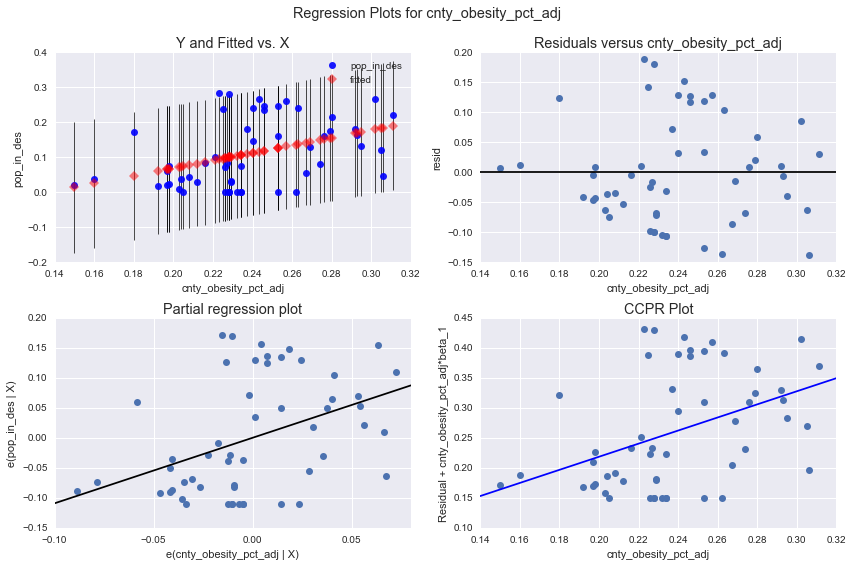

In [26]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(outs_model, "cnty_obesity_pct_adj", fig=fig)

In [27]:
mean_sum_squared_errors = np.sum((df['pop_in_des']-df['pop_in_des'].mean())**2)
regr_sum_squared_errors = np.sum((df['pop_in_des']-fitted_values)**2)
r2 = (mean_sum_squared_errors - regr_sum_squared_errors) / mean_sum_squared_errors
print("For OLS\nSSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)

mean_sum_squared_errors = np.sum((df['pop_in_des'].ix[idx]-df['pop_in_des'].ix[idx].mean())**2)
regr_sum_squared_errors = np.sum((df['pop_in_des'].ix[idx]-robust_model.fittedvalues)**2)
r2 = (mean_sum_squared_errors - regr_sum_squared_errors) / mean_sum_squared_errors
print("\nFor Robust Regression\nSSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)

mean_sum_squared_errors = np.sum((df.ix[noouts]['pop_in_des']-df.ix[noouts]['pop_in_des'].mean())**2)
regr_sum_squared_errors = np.sum((df.ix[noouts]['pop_in_des']-outs_model.fittedvalues)**2)
r2 = (mean_sum_squared_errors - regr_sum_squared_errors) / mean_sum_squared_errors
print("\nFor OLS W/o 4 outliers \nSSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)


For OLS
SSD = 1.28232351825
SSR = 1.13230279992
R2 = 0.116991317861

For Robust Regression
SSD = 0.53695315082
SSR = 0.469973020814
R2 = 0.124741106192

For OLS W/o 4 outliers 
SSD = 0.486485715161
SSR = 0.401697586767
R2 = 0.174286984698


Random Sample Consensus (RANSAC) algorithm: 

This method fits our model only to a subset of the data, it identifies as inliers. This is done by iteratively fitting the RANSACRegressor model the data that the user specifies in max_trials argument. With each iteration the model will identify inliers and outlier observations according to the Maximum residual set by the residual threshold argument. Observations meeting this threshold are classified as an inliers. The residual metric for which outliers are identified can be adjusted by the parameter residual_metric, but the default if the median absolut deviation of y. The algorithm is then terminated when the max_trials specifed is reached. 

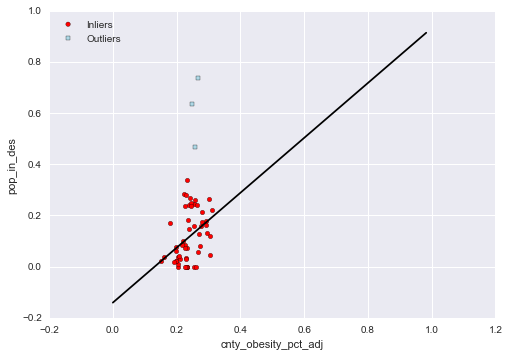

Estimated Coef: 1.074
Estimated Intercept: -0.141


In [28]:
from sklearn.linear_model import RANSACRegressor,LinearRegression


X=df[['cnty_obesity_pct_adj']].values
y=df['pop_in_des'].values

ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, min_samples=20, 
                         residual_threshold=.20)

ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(0, 1, 1/float(len(X)))
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],c='red', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='lightblue', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black')
plt.xlabel('cnty_obesity_pct_adj')
plt.ylabel('pop_in_des')
plt.legend(loc='upper left')

plt.show()

print('Estimated Coef: %.3f' % ransac.estimator_.coef_[0])
print('Estimated Intercept: %.3f' % ransac.estimator_.intercept_)

In [29]:
from sklearn.metrics import r2_score
ransac_pred = ransac.estimator_.coef_[0] * df[['cnty_obesity_pct_adj']].values +ransac.estimator_.intercept_
inlier_mask = ransac.inlier_mask_
ransac_r2=r2_score(y[inlier_mask], ransac_pred[inlier_mask])

In [30]:

mean_sum_squared_errors = np.sum((df['pop_in_des']-df['pop_in_des'].mean())**2)
regr_sum_squared_errors = np.sum((df['pop_in_des']-fitted_values)**2)
r2 = (mean_sum_squared_errors - regr_sum_squared_errors) / mean_sum_squared_errors
print("For OLS\nSSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)

mean_sum_squared_errors = np.sum((df['pop_in_des'].ix[idx]-df['pop_in_des'].ix[idx].mean())**2)
regr_sum_squared_errors = np.sum((df['pop_in_des'].ix[idx]-robust_model.fittedvalues)**2)
r2 = (mean_sum_squared_errors - regr_sum_squared_errors) / mean_sum_squared_errors
print("\nFor Robust Regression\nSSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)

mean_sum_squared_errors = np.sum((df.ix[noouts]['pop_in_des']-df.ix[noouts]['pop_in_des'].mean())**2)
regr_sum_squared_errors = np.sum((df.ix[noouts]['pop_in_des']-outs_model.fittedvalues)**2)
r2 = (mean_sum_squared_errors - regr_sum_squared_errors) / mean_sum_squared_errors
print("\nFor OLS W/o 4 outliers \nSSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)

mean_sum_squared_errors = np.sum((X[inlier_mask]-np.mean(X[inlier_mask]))**2)
np.sum((X[inlier_mask]-np.mean(X[inlier_mask]))**2)
regr_sum_squared_errors = (ransac_r2 + mean_sum_squared_errors) * mean_sum_squared_errors
r2 = ransac_r2
print("\nFor RANSAC \nSSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)


For OLS
SSD = 1.28232351825
SSR = 1.13230279992
R2 = 0.116991317861

For Robust Regression
SSD = 0.53695315082
SSR = 0.469973020814
R2 = 0.124741106192

For OLS W/o 4 outliers 
SSD = 0.486485715161
SSR = 0.401697586767
R2 = 0.174286984698

For RANSAC 
SSD = 0.0711617090909
SSR = 0.0159363761088
R2 = 0.152784234766


Excluding observations should be avoided if possible. Excessive data tinkering and "stats-smithing" can result in misleading results instead of results that are grounded in truth. 
_______
### Conclusion
* #### Counties with a greater percentage of citizens living in food deserts tend to also have a greater percentage of obese citizens.
* ####  County level obesity rate is a useful measure in predicting the percentage of citizens living in food deserts. In most California counties, for every 1% increase in county level diabetes rates, we can also expect to see approximately 1.09% more citizens living in Food deserts.

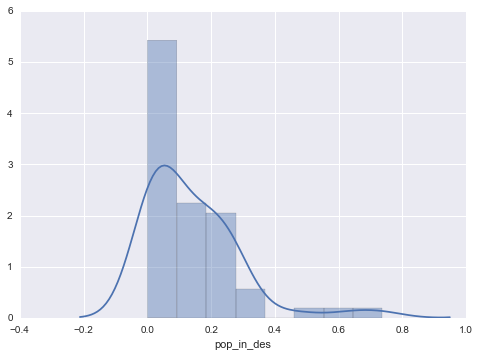

In [31]:
sns.distplot(df['pop_in_des'])

________

## Baysian Approach - PyMC3

#### * Hypothesis:
Counties that have many residents effected by food deserts have are more likely to have less residents that are high school graduates.  


____

We will test this hypothesis using a probalistic approach, but first lets try a measure the performance of a OLS model for comparison.

In [32]:

def remove_ouliers(x_array, y_array):
    from sklearn.linear_model import RANSACRegressor,LinearRegression
    ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, min_samples=20, 
                         residual_threshold=.20)
    ransac.fit(X, y)
    return ransac.inlier_mask_


o = remove_ouliers(df['pop_in_des'].values,  df['p_hs_edatt'].values)

df = df[['p_hs_edatt', 'pop_in_des']]
df = df.ix[o]

model1 = smf.ols(formula='pop_in_des ~ p_hs_edatt', data=df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             pop_in_des   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     8.351
Date:                Wed, 10 Aug 2016   Prob (F-statistic):            0.00557
Time:                        21:57:27   Log-Likelihood:                 53.285
No. Observations:                  55   AIC:                            -102.6
Df Residuals:                      53   BIC:                            -98.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.5079      0.136      3.722      0.000         0.234     0.782
p_hs_edatt    -0.4798      0.166     -2.890      0.006        -0.813    -0.147
==============================================================================
Omnibus:                        7.271   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                4.827
Skew:                           0.570   Prob(JB):                       0.0895
Kurtosis:                       2.101   Cond. No.                         22.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Bayesian Regression


$$Y∼N(Xβ,σ2)$$

Y remains the variable in which we are interested in predicting. But instead of one line posterior distribution is returned, which contains probabilities for the values of Y.  The advantage to this approach is that it incorporates prior knowledge that we have about our dependent variable by allowing us to specify a prior distribution through σ2. Here we can specify what we believe the shape or our dependent variable is, as well as the mean and standard deviation. This type of model also tells us how certain we can be in our results because it returns probilities of value Y at a given X rather than one line: $$y=X*slope+intercept$$  This keeps our analysis easily interperable and more reflective of ground truths. 


In [33]:
from pymc3 import  *



x=df['p_hs_edatt'].values
y=df['pop_in_des'].values
data=dict(x=x,y=y)

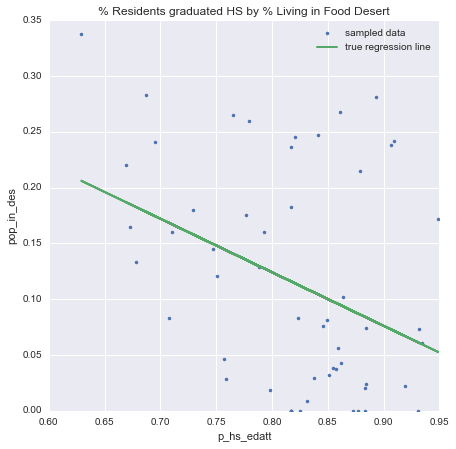

In [34]:


pred=model1.predict(pd.DataFrame(df['p_hs_edatt']))
true_regression_line = pred

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='p_hs_edatt', ylabel='pop_in_des', title='% Residents graduated HS by % Living in Food Desert')
ax.plot(x, y, '.', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

To build a Bayesian model, we will use a similar format to what was used previously with statsmodels (both use Patsy to allow formula arguments).  PyMC3's glm (general linear model) makes this quite more simple than the first version of PyMC.  First we define our model by specifying the dependent, explanatory variables, and the data container. Then we specify our model's Max A-Posteriori (MAP) point from which samples will be drawn, and instantiate the sampler. NUTS is a Markov-Chain Monte Carlo (MCMC) sampler that is included in PyMC3 that adjusts the sample steps to optimize performance. Finally, we define our trace which includes the number of samples we want to draw, the step size, starting point, and whether we want the progress bar to disply during the sampling process.

In [35]:
with Model() as model:
    # Specify glm and pass in variables and dataset including variables
    glm.glm('y ~ x', data)
    start = find_MAP() # pymc3 function tof ind Max A-Posteriori (MAP) point from which samples will be drawn
    step = NUTS(scaling=start) # Instantiate MCMC sampling algorithm, start using at the start identified by find_MAP
    trace = sample(2000, step, progressbar=True) # draw 3000 posterior samples using NUTS sampling

Applied log-transform to sd and added transformed sd_log to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 3.3 sec

Now we have our model.  Since our output is different, we have to evaluate differently from our previous models. Lets plot the posterior distributions returned from our model, and the samples that were drawn to obtaine them in the cell below.  


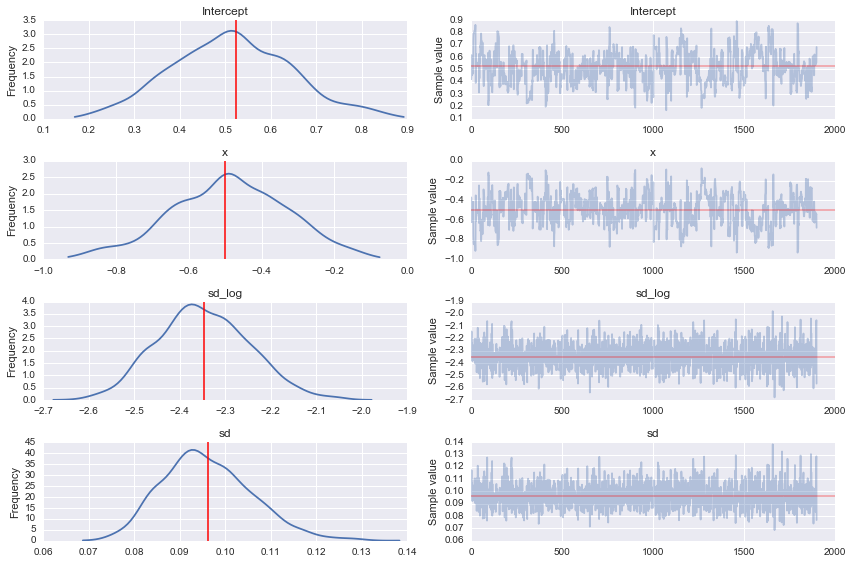

In [36]:
plt.figure(figsize=(7, 7))
traceplot(trace[100:],lines={k: v['mean'] for k, v in df_summary(trace[-1000:]).iterrows()})
plt.tight_layout();

In [37]:
x
model1.params
np.std(y)

0.098806804221018563

The left side shows our marginal posteriors for every parameter values shown on the x axis, which is interpreted as how likely each value is for corresponding variable. In this model we have the probability distributions for the intercept, x (% residents graduated high school), sd_log, and sd (both variables added during sampling). The left columns show the sampling chains that were drawn for the model. 


In these graphs we should looking for the following:
* Convergence and stationarity of the sampling chains in the plots in the left column. 
* The values for the the maximum posterior estimate should make sense. 
     -  Meaning the peak of the distribution for x should be somewhat similar to the coeff of x in the linear model, and sd, also called sigma, is close to the standard deviation of our dependent variable y. 

Both are true in this instance as we can see below:

In [38]:
# sd looks similiar to np.std(y), the std of target
print "The peak of sd's distribution should be close to...", np.std(y)
# x looks similiar to x's coef in linear model
print "The peak of x's distribution should be close to...", model1.params[1]

The peak of sd's distribution should be close to... 0.098806804221
The peak of x's distribution should be close to... -0.479823354675


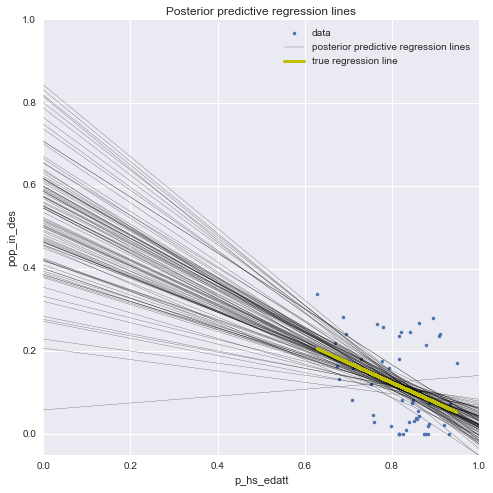

In [39]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, '.', label='data')
glm.plot_posterior_predictive(trace, samples=100, 
                              label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.ylim(-0.05,1.0)
plt.xlabel('p_hs_edatt')
plt.ylabel('pop_in_des')
plt.tight_layout();

The plot above shows the 100 posterior predictive regression lines, and the true regression line. The 100 samples that were taken from our models trace contain varying values for the probable slope and intercept values. Areas where greater variabilty is present amongst the lines express uncertainty, due to the fact few observations held these values. When we adjust the x-axis we are better able to compare our models.

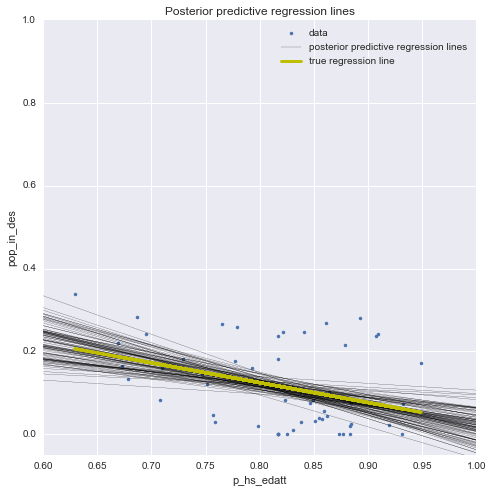

In [40]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, '.', label='data')
glm.plot_posterior_predictive(trace, samples=100, 
                              label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlim(0.60,1.00)
plt.ylim(-0.05,1.0)
plt.xlabel('p_hs_edatt')
plt.ylabel('pop_in_des')
plt.tight_layout();

#### Again, this one of the best features about Bayesian statistics. We can express how unsure we are about our results, which makes predictions more easy to interperet, and therefore more actionable to those listening to our analysis!

And finally,  we can also assess the test statistics associated with our model.

In [41]:
bayes_summary = df_summary(trace)
bayes_summary.columns = ['mean', 'std','sampling_err', 
                        'lower_credible_bound_2.5%','upper_credible_bound_97.5%']
bayes_summary



,mean,std,sampling_err,lower_credible_bound_2.5%,upper_credible_bound_97.5%
Intercept,0.512190,0.134455,0.008407,0.243061,0.774249
x,-0.485329,0.163219,0.010202,-0.796913,-0.151089
sd_log,-2.346529,0.103064,0.002686,-2.523870,-2.131059
sd,0.096214,0.010062,0.000264,0.078755,0.116742


This means we can confidently conclude that counties that have many residents effected by food deserts are more likely to have less residents who are high school graduates. 
Our analysis suggests for every 1% increase in food deserts population, we can expect approximately 4.9% decrease in the number of high school graduate residents!
______________

PyMC3 has very stringent formatting. That said, this portion of the notebook references the following tutorials heavily. 

##### Refernces:
http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/   
https://pymc-devs.github.io/pymc3/notebooks/GLM-linear.html

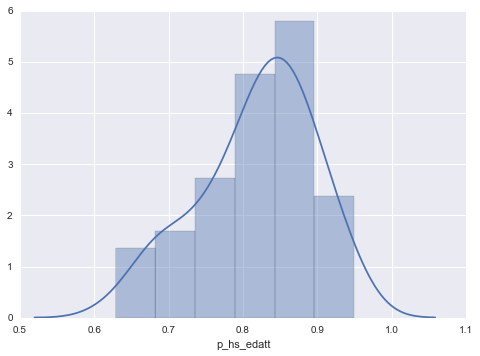

In [42]:
df['pop_in_des']
sns.distplot(df['p_hs_edatt'])